# Imports

In [1]:
import os, sys

dtype = "float32"
MAIN = "/Users/abidaurrazaga/Desktop/PhD/StructuralRBM"
nb_path = '/Users/abidaurrazaga/Desktop/PhD/StructuralRBM/Modules'
sys.path.append(nb_path)

import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from RBM import RBM,SBM
from ClassRBM import ClassRBM,ClassSBM 

import warnings
warnings.filterwarnings("ignore")
kwargs = {}

ModuleNotFoundError: No module named 'sparseupdate'

In [ ]:
from sklearn.covariance import EmpiricalCovariance as Cov
from Save_Load import from_dataset_to_array
import seaborn as sb
from utils import read_home_dir
from Save_Load import check_rbm,save_rbm

In [ ]:
def Experiment(args):

    """Computes a 10-repeated-hold-out experiment for a model with different seeds, model parameters are given by args"""
    
    MAIN = read_home_dir()
    
    #######################################################
    
    TASK = args.get("TASK") # "Unsupervised" or "Supervised"
    DATA_NAME= args.get("DATA_NAME") # "MNIST" or "FashionMNIST"
    nHidden = args.get("nHidden",0)
    
    window = args.get("window",0)
    stride = args.get("stride",0)
    
    window_list = args.get("window_list",[])
    stride_list = args.get("stride_list",[])

    n_fold = args.get("n_fold",0)

    train_size = args.get("train_size",0)
    batch_size = Launch_Experiments.batch_size

    
    #######################################################
    EPOCHS = 10#Launch_Experiments.EPOCHS
    lr = Launch_Experiments.lr
    momentum = Launch_Experiments.momentum
    
    n_step = Launch_Experiments.n_step
    
    unsuper_metrics = Launch_Experiments.unsuper_metrics
               
    super_metrics = Launch_Experiments.super_metrics

    train_corrupted,val_corrupted = None,None

    if DATA_NAME == "MNIST":
        train_data,train_data_y = from_dataset_to_array(data_name = "identity", split = "train",size = train_size)
        val_data,val_data_y = from_dataset_to_array(data_name = "identity", split = "val")
    elif DATA_NAME == "FashionMNIST":
        train_data,train_data_y = from_dataset_to_array(data_name = "fashion_mnist", split = "train",size = train_size)
        val_data,val_data_y = from_dataset_to_array(data_name = "fashion_mnist", split = "val")
    else:
        train_data,train_data_y = from_dataset_to_array(data_name = DATA_NAME, split = "train",size = train_size)
        val_data,val_data_y = from_dataset_to_array(data_name = DATA_NAME, split = "val")
    OUTPUT_DIR = "Trained RBM/"+DATA_NAME
    if not os.path.exists(os.path.join(MAIN,OUTPUT_DIR)):
        os.mkdir(os.path.join(MAIN,OUTPUT_DIR))
        
    if TASK == "Unsupervised":
        method = "LL"
        train_corrupted,_ = from_dataset_to_array(data_name = "shot_noise", split = "train",size = train_size)
        val_corrupted,_ = from_dataset_to_array(data_name = "shot_noise", split = "val")
        metrics = unsuper_metrics
    elif TASK == "Supervised":
        method = "discriminative"
        metrics = super_metrics
    
    
    for SEED in range(10):
    
        # Set model arguments
        kwargs = dict(batch_size = batch_size,nVisible = train_data.shape[1],nHidden = nHidden, nClass = train_data_y.shape[1], train_size = train_size,
                          window = window, stride = stride, window_list = window_list, stride_list = stride_list, n_fold = n_fold, name = "_"+DATA_NAME,
                          epochs = EPOCHS,k_gibbs = 1, MAIN = MAIN,metrics = metrics,seed = SEED, output_dir = OUTPUT_DIR, method = method,
                          train_data=train_data,val_data=val_data,train_corrupted=train_corrupted,val_corrupted=val_corrupted,n_step=n_step,
                          train_data_y=train_data_y,val_data_y=val_data_y,min_updates = Launch_Experiments.PATIENCE,nAIS=1,
                          lr = lr,momentum = momentum, dtype = Launch_Experiments.dtype,LL_epochs = 100)
                          
        if TASK == "Unsupervised":
            if nHidden:
                model = RBM(**kwargs)
            else:
                model = SBM(**kwargs)
        elif TASK == "Supervised":
            if nHidden:
                model = ClassRBM(**kwargs)
            else:
                model = ClassSBM(**kwargs)
            
        model.batch_size = batch_size
        model.epochs = EPOCHS
        
        print("Name of the RBM: %s"%model.get_name())
        name = model.get_name()
        if check_rbm(name,**kwargs):
            print("Already computed and stored in %s"%(os.path.join(MAIN,OUTPUT_DIR,name)))
            continue
        
        model.fit(**kwargs) # Train model
        
        save_rbm(model,**kwargs) # Save model

In [ ]:
import Launch_Experiments
def locally(DATA_NAME,TASK = "Unsupervised"):
    
    MAIN_DICT = [dict(item,DATA_NAME = DATA_NAME,TASK=TASK,leave_bar=False) for item in Launch_Experiments.PARAMS_DICT_5]
    MAIN_DICT = [dict(DATA_NAME = DATA_NAME,TASK=TASK,leave_bar=False,window=3,stride=2)] 
        
    for i in range(len(MAIN_DICT)):
        
        Experiment(MAIN_DICT[i])
locally("MNIST","Unsupervised")

NameError: name 'Experiment' is not defined

# Metric to determine SBM adecuacy

In [ ]:
data_name = "identity"
data,lab = from_dataset_to_array(data_name = data_name)

In [ ]:
w = 1
t = 2
mask = hiddenVisible_mask(window=w,t_x=t,t_y=t,nVisible=data.shape[1])

In [ ]:
cov_mask = np.zeros((data.shape[1],data.shape[1]))
for j in range(mask.shape[1]):
    visibles = np.where(mask[:,j]==1)[0]
    for i in range(len(visibles)):
        for k in range(i,len(visibles)):
            cov_mask[visibles[i],visibles[k]] = 1
            cov_mask[visibles[k],visibles[i]] = 1
sb.heatmap(cov_mask)

In [ ]:
cov1 = Cov().fit(data).covariance_
cov2 = cov_mask*cov1
sb.heatmap(cov1)
plt.show()
sb.heatmap(cov2)
plt.show()

# Determinant of the covariance matrix

In [ ]:
import scipy
det1 = scipy.linalg.det(cov1)
det2 = scipy.linalg.det(cov2)

In [ ]:
det1 = np.linalg.slogdet(cov1)
det2 = np.linalg.slogdet(cov2)

In [ ]:
det2

In [ ]:
entropy_diff = np.log(det1/det2)
print(entropy_diff)

In [ ]:
metric = np.mean(np.abs(cov1-cov2))
print(data_name)
print(metric)

In [ ]:
datasets = ["identity","fashion_mnist","breastmnist","pneumoniamnist","chestmnist"]
w = 2
t = 3
mask = hiddenVisible_mask(window=w,t_x=t,t_y=t,nVisible=data.shape[1])
cov_mask = np.zeros((data.shape[1],data.shape[1]))
for j in range(mask.shape[1]):
    visibles = np.where(mask[:,j]==1)[0]
    for i in range(len(visibles)):
        for k in range(i,len(visibles)):
            cov_mask[visibles[i],visibles[k]] = 1
            cov_mask[visibles[k],visibles[i]] = 1
metrics = []
for data_name in datasets:
    data,lab = from_dataset_to_array(data_name = data_name)
    cov1 = Cov().fit(data).covariance_
    cov2 = cov_mask*cov1
    metric = np.mean(np.abs(cov1-cov2))
    metrics.append(metric)
for data_name,metric in zip(datasets,metrics):
    print("Data: %s, metric: %s\n"%(data_name,metric))

# Linear regresion

In [9]:
from sklearn.linear_model import LinearRegression as linreg
import Launch_Experiments
from Save_Load import from_dataset_to_array
from Mask import hiddenVisible_mask
from RBM import RBM
import pandas as pd
import seaborn as sn
data_dict = {"pneumoniamnist":"Pneumonia",
            "breastmnist":"Breast",
            "identity":"MNIST",
            "fashion_mnist":"Fashion"}
PARAMS_DICT_1 = [{"window":1,"stride":2,"model_name":"SBM 196"},
                {"window_list":[1,2],"stride_list":[3,3],"model_name":"SBM 162"},
                {"window":3,"stride":2,"model_name":"SBM 144"},
                {"window_list":[2,3,4],"stride_list":[4,4,4],"model_name":"SBM 121"},
                {"window":2,"stride":3,"model_name":"SBM 81"},
               ]
SIZE = 500
PARAMS_DICT_1 = [{"window_list":[4,4],"stride_list":[2,1],"model_name":"SBM 562"},
                {"window_list":[3,4],"stride_list":[2,1],"model_name":"SBM 585"},
                {"window_list":[3,4],"stride_list":[2,2],"model_name":"SBM 265"},
                {"window":4,"stride":1,"model_name":"SBM 441"},
                {"window":4,"stride":2,"model_name":"SBM 121"},
                {"window":3,"stride":2,"model_name":"SBM 144"},
               ]

In [10]:
columns = ["Model","Dataset","Mean_score_diff","Std_score_diff"]

df = pd.DataFrame(columns=columns)
for key in data_dict:
    score1 = []

    data,_ = from_dataset_to_array(data_name = key,size = SIZE)
    #print(data.shape)

    for ind in range(data.shape[1]):
        if ind%100==0:
            print(ind)
        d = data[:,np.arange(data.shape[1])!=ind]
        reg = linreg().fit(d,data[:,ind])
        score1.append(reg.score(d,data[:,ind]))

    for args in PARAMS_DICT_1:
        print(args["model_name"])
        score = []
        values = [args["model_name"],data_dict[key]]
        ind_dict = dict()
        window = args.get("window",0)
        stride = args.get("stride",0)
        
        window_list = args.get("window_list",[])
        stride_list = args.get("stride_list",[])
        rbm = RBM(window=window,stride=stride,window_list=window_list,stride_list=stride_list,nVisible=data.shape[1])
        mask = rbm.mask
        for h in range(mask.shape[1]):
            neigh_indexes = np.where(mask[:,h]==1)[0]
            for ind in neigh_indexes:
                if ind in ind_dict:
                    ind_dict[ind].append(neigh_indexes[np.where(neigh_indexes!=ind)])
                else:
                    ind_dict[ind] = [neigh_indexes[np.where(neigh_indexes!=ind)]]


        for ind in range(data.shape[1]):
            #if ind%100==0:
            #    print(ind)
            s = []
            for neigh in ind_dict[ind]:
                d = data[:,neigh]
                reg = linreg().fit(d,data[:,ind])
                s.append(reg.score(d,data[:,ind]))
            score.append(np.mean(s))
        dif = np.array(score1)-np.array(score)
        values.append(np.mean(dif))
        values.append(np.std(dif))
        df.loc[len(df.index)] = values
    print(df)

Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/pneumoniamnist.npz
Size 4708
0
100
200
300
400
500
600
700
SBM 562


2022-09-26 17:42:27.352206: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


SBM 585
SBM 265
SBM 441
SBM 121
SBM 144
     Model    Dataset  Mean_score_diff  Std_score_diff
0  SBM 562  Pneumonia         0.003304        0.003969
1  SBM 585  Pneumonia         0.003590        0.004207
2  SBM 265  Pneumonia         0.003817        0.005064
3  SBM 441  Pneumonia         0.003295        0.003909
4  SBM 121  Pneumonia         0.003192        0.004445
5  SBM 144  Pneumonia         0.004630        0.005964
Using downloaded and verified file: /Users/abidaurrazaga/.medmnist/breastmnist.npz
Size 546
0
100
200
300
400
500
600
700
SBM 562
SBM 585
SBM 265
SBM 441
SBM 121
SBM 144
      Model    Dataset  Mean_score_diff  Std_score_diff
0   SBM 562  Pneumonia         0.003304        0.003969
1   SBM 585  Pneumonia         0.003590        0.004207
2   SBM 265  Pneumonia         0.003817        0.005064
3   SBM 441  Pneumonia         0.003295        0.003909
4   SBM 121  Pneumonia         0.003192        0.004445
5   SBM 144  Pneumonia         0.004630        0.005964
6   SBM 562  

In [11]:
df.to_csv(os.path.join(MAIN,"CSV","Scores_datasets_new_models"))

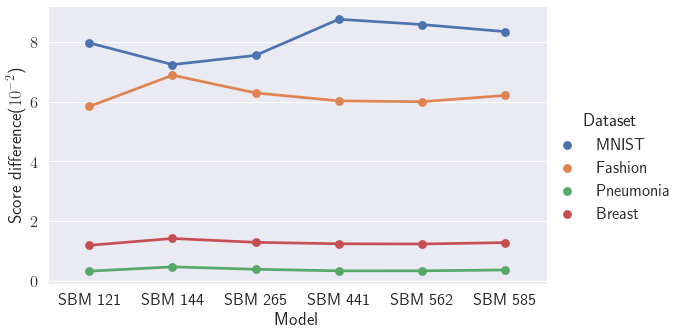

In [14]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Lucida"]})
df = pd.read_csv(os.path.join(MAIN,"CSV","Scores_datasets_new_models"))
df["Mean_score_diff"] = 100*df["Mean_score_diff"]
sn.set(font_scale=1.5)
ax = sn.catplot(data=df,x="Model",y="Mean_score_diff",order=["SBM 121","SBM 144","SBM 265","SBM 441","SBM 562","SBM 585"],hue="Dataset",kind="point",
height=5,aspect=1.6,hue_order = ["MNIST","Fashion","Pneumonia","Breast"])
ax.set(ylabel="Score difference($10^{-2}$)")
#ax.fill_between(df["Model"], y1=df["Mean_score_diff"] - df["Std_score_diff"], y2=df["Mean_score_diff"] + df["Std_score_diff"], alpha=.5)
plt.savefig(os.path.join(MAIN,"Images","SBM_metric_new_models.pdf"))

# CNN to check how it works with MNIST-C

In [ ]:
#importing the necessary modules
from keras.datasets import mnist
import numpy as np

(xtrain,ytrain),(xtest,ytest)=mnist.load_data()

#reshaping data as needed by the model
xtrain=np.reshape(xtrain,(-1,28,28,1))
xtest=np.reshape(xtest,(-1,28,28,1))
xtrain.shape,xtest.shape,ytrain.shape,ytest.shape

#normalising
xtrain=xtrain/255
xtest=xtest/255

#implementing one hot encoding
from keras.utils.np_utils import to_categorical
y_train = to_categorical(ytrain, num_classes=10)
y_test = to_categorical(ytest, num_classes=10)

In [ ]:
#importing the model
from keras.models import Sequential
import keras

model=Sequential()

from keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout

#adding layers and forming the model
model.add(Conv2D(32,kernel_size=5,strides=1,padding="Same",activation="relu",input_shape=(28,28,1)))
model.add(MaxPooling2D(padding="same"))

model.add(Conv2D(64,kernel_size=5,strides=1,padding="same",activation="relu"))
model.add(MaxPooling2D(padding="same"))

model.add(Flatten())

model.add(Dense(1024,activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10,activation="sigmoid"))

#compiling
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["log_loss"])

In [ ]:
#training the model
TRAIN = False
if TRAIN:
    model.fit(xtrain,y_train,batch_size=100,epochs=5,validation_data=(xtest,y_test))
    model.save(os.path.join(MAIN,'CNN_MNIST.h5'))
else:
    model = keras.models.load_model(os.path.join(MAIN,'CNN_MNIST.h5'))


In [ ]:
model.evaluate(xtrain,y_train),model.evaluate(xtest,y_test)

In [ ]:
import Launch_Experiments
import pandas as pd
df = pd.DataFrame(columns=["Noise_name","corrupted_logloss"])
for corruption in Launch_Experiments.CORRUPTIONS:
    test_corrupted,test_label = from_dataset_to_array(data_name = corruption,split = "test")
    test_corrupted=np.reshape(test_corrupted,(-1,28,28,1))
    #test_label = to_categorical(test_label, num_classes=10)
    values = [corruption,model.evaluate(test_corrupted,test_label)[0]]
    df.loc[len(df.index)] = values

In [ ]:
import seaborn as sn
DATA_NAME = "CNN_MNIST_C"
TASK = "Supervised"
versus = "nHidden"
metric = "corrupted_logloss"
ax = sn.catplot(x="Noise_name", y=metric,

                data=df, kind="bar",

                height=4, aspect=1.6,sharey=False,margin_titles=False)

ax.set(ylabel="Log-loss")
ax.set(xlabel=None)

#ax.set_titles(template='{col_name}')
ax.set_xticklabels(rotation=30)

plt.savefig(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
print(os.path.join(MAIN,"Images","%s_%s_%s_%s.pdf"%(DATA_NAME,TASK,metric,versus)))
plt.show()

# Load MedMNIST

In [ ]:
#!pip install medmnist

In [ ]:
from tqdm import tqdm
import numpy as np

import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

In [ ]:
import dataset_without_pytorch

from dataset_without_pytorch import get_loader

In [ ]:
INFO

In [ ]:
data_flag = 'chestmnist'
# data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
nClasses = len(info['label'])

NUM_EPOCHS = 3
SPLIT = "val"
BATCH_SIZE = info["n_samples"][SPLIT]
lr = 0.001

DataClass = getattr(dataset_without_pytorch, info['pythonClass'])

In [ ]:
# load the data
train_dataset = DataClass(split=SPLIT, download=download)

# encapsulate data into dataloader form
train_loader = get_loader(dataset=train_dataset, batch_size=BATCH_SIZE)

In [ ]:
train_dataset.montage(length=20)

In [ ]:
for x,y in train_loader:
    print(type(x))
    print(type(y))
    print(x.shape)
    print(y.shape)
    break

# Unsupervised learning

## Load data and split into train/valid sets

In [ ]:
from Save_Load import from_dataset_to_array

print("This may take some time")
CORRUPTED,CORRUPTED_LABEL = from_dataset_to_array(data_name = "shot_noise") 
DATA,DATA_LABEL = from_dataset_to_array(data_name = "identity")

val_split = 1/3
train_data,val_data = train_test_split(DATA, test_size = val_split,random_state = 42)
train_corrupted,val_corrupted = train_test_split(CORRUPTED, test_size = val_split,random_state = 42)


## Set metrics to measure during training

In [ ]:
"""Different parameters like patience or minimum change (min_delta) can be set to apply earlystopping"""

metrics = [{"name":"recon_mse","patience":10,"min_delta":0.0,"optimize":""},
               {"name":"free_energy","patience":10,"max_value":5,"optimize":""},
               {"name":"LL","patience":10,"min_delta":0.0000,"optimize":"max"}]

## Set RBM and training parameters


In [ ]:
EPOCHS = 21 # Time to train for each epoch approx 1 minute, and each model is repeated 10 times, thus, elapsed time will be [0.15,0.22]*epochs hours.
             # For 100 epochs, maximum time limit should be 24 hours. 
             # Partitions(Walltime in hours)-> short(0.5), medium(6), large(120)

lr = 0.01
momentum = 0.5
batch_size = 2**6
SEED = 9

nHidden = 1000#81*5

window = 1
stride = 2

window_list = []#[2,3,4]
stride_list = []#[4,4,4]


dim = 28

kwargs = vars_to_dict(batch_size = batch_size,nVisible = 28*28,nHidden = nHidden,
                      window = window, stride = stride, window_list = window_list, stride_list = stride_list,
                      epochs = EPOCHS,k_gibbs = 1,
                      MAIN = MAIN,metrics = metrics,train_data=train_data,val_data=val_data,
                      train_corrupted=train_corrupted,val_corrupted=val_corrupted,seed = SEED,
                      lr = lr,momentum = momentum, dtype = dtype)


### Initialise and train model

In [ ]:
kwargs["n_fold"] = 5
rbm = RBM(**kwargs)
rbm.batch_size = batch_size
rbm.epochs = EPOCHS
print("Name of the RBM if saved: %s"%rbm.get_name())
rbm.K = 2000
rbm.M = 512
rbm.fit(LL_epochs = 5,**kwargs)

## Save/Load the model for future evaluations


In [ ]:
from Save_Load import save_rbm,load_rbm

save_rbm(rbm,**kwargs)

In [ ]:
rbm = load_rbm("RBM_nHidden_196_method_LL_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_095_batch_size_16",MAIN=MAIN)

## Visualise results


###  Visualise measured metrics(LL is computed every 5 epochs)

In [ ]:
from Plot import plot_errors

for metric in metrics:
  plot_errors([rbm.history[s+metric["name"]] for s in ["train_","val_"]],
              [("$"+s+metric["name"]+"$").replace("_","\_") for s in ["train_","val_"]],ylabel = metric["name"],title = "" )


# Classifier RBM

In [ ]:
#Supervised Learning
#Load data and split into train/valid sets

from Save_Load import from_dataset_to_array

size = -1

#CORRUPTED,CORRUPTED_LABEL = from_dataset_to_array(data_name = "shot_noise",size = size) 
DATA,DATA_LABEL = from_dataset_to_array(data_name = "fashion_mnist", size = size)

val_split = 1/3
train_data,val_data = train_test_split(DATA, test_size = val_split,random_state = 42)
#train_corrupted,val_corrupted = train_test_split(CORRUPTED, test_size = val_split,random_state = 42)

#One-hot labels

from sklearn.preprocessing import OneHotEncoder

train_data_y,val_data_y = train_test_split(DATA_LABEL, test_size = val_split,random_state = 42)
#train_corrupted_y,val_corrupted_y = train_test_split(CORRUPTED_LABEL, test_size = val_split,random_state = 42)

enc = OneHotEncoder(sparse = False,dtype = "float32")
enc.fit(np.array([i for i in range(10)]).reshape(-1,1))
train_data_y = enc.transform(train_data_y.reshape(-1,1))
val_data_y = enc.transform(val_data_y.reshape(-1,1))
#train_corrupted_y = enc.transform(train_corrupted_y.reshape(-1,1))
#val_corrupted_y = enc.transform(val_corrupted_y.reshape(-1,1))

#Set metrics to measure during training

"""Different parameters like patience or minimum change (min_delta) can be set to apply earlystopping"""

metrics = [{"name":"roc","min_delta":0.00001,"optimize":"max"},
           {"name":"accuracy","min_delta":0.00001,"optimize":"max"},]


In [ ]:
EPOCHS = 20
lr = 0.5
momentum = 0.9
SEED = 42
batch_size = 2**6

nVisible = 28*28
nClass = 10
nHidden = 196

window = 1
stride = 2

window_list = []
stride_list = []

dim = 28

kwargs = vars_to_dict(batch_size = batch_size,nVisible = nVisible,nHidden = nHidden,nClass = nClass,
                      window = window, stride = stride, window_list = window_list, stride_list = stride_list,
                      #mask = mask,name = "_permuted_neighbours",
                      epochs = EPOCHS,k_gibbs = 1,MAIN = MAIN,metrics = metrics,train_size = size,
                      train_data=train_data,val_data=val_data, name = "_FashionMNIST",
                      train_data_y=train_data_y,val_data_y=val_data_y,
                      seed = SEED,lr = lr,momentum = momentum, dtype = dtype)

#Initialize and train the model

classrbm = classRBM(**kwargs)
classrbm.batch_size = batch_size
classrbm.epochs = EPOCHS
print("Name of the RBM if saved: %s"%classrbm.get_name())
classrbm.fit(**kwargs)

In [ ]:
from Save_Load import save_rbm,load_rbm

save_rbm(classrbm,**kwargs)

In [ ]:
from Plot import plot_errors

for metric in metrics:
  plot_errors([classrbm.history[s+metric["name"]] for s in ["train_","val_"]],
              [("$"+s+metric["name"]+"$").replace("_","\_") for s in ["train_","val_"]],ylabel = metric["name"],title = "" )

In [ ]:
#Confusion matrix on test

TEST,TEST_LABEL = from_dataset_to_array(data_name = "fashion_mnist",split = "test", size = size)
 
enc = OneHotEncoder(sparse = False,dtype = "float32")
enc.fit(np.array([i for i in range(10)]).reshape(-1,1))
TEST_LABEL = enc.transform(TEST_LABEL.reshape(-1,1))

from sklearn.metrics import confusion_matrix as Confusion
import matplotlib.pyplot as plt
import seaborn as sn

y_true = enc.inverse_transform(TEST_LABEL)
y_pred = enc.inverse_transform(classrbm.sample_class_from_probs(classrbm.predict(TEST)))

conf_mat = Confusion(y_true,y_pred)
plt.figure(figsize = (10,7))
fig = sn.heatmap(conf_mat, annot=True)

from sklearn.metrics import accuracy_score as ACCURACY

print("Accuracy on Test: %s"%ACCURACY(y_true,y_pred))

print("Percentage of number of parameters with respect to the free model: %s"%round(100*np.sum(classrbm.mask)/np.sum(np.ones(classrbm.mask.shape)))+"%")

In [ ]:

#Visualise reconstruction

from Plot import plot_reconstruction

CORRUPTION = "shot_noise"
fig,ax = plot_reconstruction(rbm,corruption = CORRUPTION,n=10,title = "Reconstruction %s"%CORRUPTION,save = False,
                             k=1,figsize = (12,6))

#Multiple corruption reconstruction error boxplots

CORRUPTIONS = [
    'shot_noise',
    'impulse_noise',
    'glass_blur',
    'motion_blur',
    'fog',
    'spatter',
    'dotted_line',
    'zigzag',
]

from Plot import evaluate_corruption_recon,boxplots

errors = evaluate_corruption_recon(rbm,corruptions=CORRUPTIONS)

boxplots(errors,labels = CORRUPTIONS,title = "Model reconstruction error for different corruptions")

#Optimize hyperparameters

from BayesOpt import *

from Save_Load import from_dataset_to_array

CORRUPTED,CORRUPTED_LABEL = from_dataset_to_array(data_name = "shot_noise") 
DATA,DATA_LABEL = from_dataset_to_array(data_name = "identity")

val_split = 1/3
train_data,val_data = train_test_split(DATA, test_size = val_split,random_state = 42)
train_corrupted,val_corrupted = train_test_split(CORRUPTED, test_size = val_split,random_state = 42)

metrics = [{"name":"recon_mse","patience":30,"min_delta":0.0000,"optimize":"min"},
           {"name":"free_energy","max_value":2.0,"optimize":"min"},
           {"name":"LL","patience":20,"min_delta":0.000000,"optimize":"max"}]

EPOCHS = 20
lr = 1E-3
momentum = 0.05
SEED = 42
batch_size = 2**4

nHidden = 0

window = 1
stride = 2

window_list = []
stride_list = []


dim = 28

default_kwargs = vars_to_dict(batch_size = batch_size,nVisible = 28*28,nHidden = nHidden,
                      window = window, stride = stride, window_list = window_list, stride_list = stride_list,
                      epochs = EPOCHS,k = 1,
                      MAIN = MAIN,metrics = metrics,train_data=train_data,val_data=val_data,
                      train_corrupted=train_corrupted,val_corrupted=val_corrupted,seed = SEED,
                      lr = lr,momentum = momentum, dtype = dtype,objective = "train_LL",optimize = "max")

VARIABLES = [{'name': 'lr', 'type': 'continuous', 'domain': (1E-5,1E-1)},
             {'name': 'momentum', 'type': 'continuous', 'domain': (0.,0.99)}]

Optimizer = BayesOpt(variables = VARIABLES,**default_kwargs,mins=10)

print(Optimizer.Y,Optimizer.X)

Optimizer.fx_opt

Optimizer.x_opt

#Multiple experiments
#Load data

from Save_Load import from_dataset_to_array

CORRUPTED,CORRUPTED_LABEL = from_dataset_to_array(data_name = "shot_noise") 
DATA,DATA_LABEL = from_dataset_to_array(data_name = "identity")

val_split = 1/3
train_data,val_data = train_test_split(DATA, test_size = val_split,random_state = 42)
train_corrupted,val_corrupted = train_test_split(CORRUPTED, test_size = val_split,random_state = 42)

#Set metrics

"""Different parameters like patience or minimum change (min_delta) can be set to apply earlystopping"""

metrics = [{"name":"recon_mse","patience":30,"min_delta":0.0000,"optimize":"min"},
           {"name":"free_energy","max_value":2.0,"optimize":"min"},
           {"name":"LL","patience":20,"min_delta":0.000000,"optimize":"max"}]

#Set parameters for each model (nHidden,window,...)

experiments = [{"nHidden":64},{"nHidden":100},{"nHidden":196},
               {"window":1,"stride":2},{"window":2,"stride":2},
               {"window":3,"stride":2},
               {"window":5,"stride":2},{"window":5,"stride":3},
               {"window_list":[3,4],"stride_list":[7,5]},{"window_list":[5,4],"stride_list":[4,4]},
               {"window_list":[2,4],"stride_list":[3,4]},{"window_list":[2,5],"stride_list":[3,4]}]

EPOCHS = 20
lr = 0.01
momentum = 0.4
SEED = 42
batch_size = 2**4


dim = 28

default_kwargs = vars_to_dict(batch_size = batch_size,nVisible = 28*28, epochs = EPOCHS,k = 1,
                      MAIN = MAIN,metrics = metrics,train_data=train_data,val_data=val_data,
                      train_corrupted=train_corrupted,val_corrupted=val_corrupted,seed = SEED,
                      lr = lr,momentum = momentum, dtype = dtype,objective = "train_LL",optimize = "max")

#Run experiments

from Save_Load import save_rbm,load_rbm

for exp in experiments:
  kwargs = default_kwargs.copy()
  for key in exp:
    kwargs[key] = exp[key]
  rbm = RBM(**kwargs)
  rbm.batch_size = batch_size
  rbm.epochs = EPOCHS
  if os.path.isfile(os.path.join(MAIN,kwargs.get("output_dir","Trained RBM/MNIST"),rbm.get_name())):
    if not kwargs.get("repeat",False):
      continue
  print(rbm.get_name())
  rbm.fit(**kwargs)
  save_rbm(rbm,**kwargs)
  print("Final train LL: "%rbm.history["train_LL"][rbm.opt_ind])
  print("")

#Supervised Learning
#Load data and split into train/valid sets

from Save_Load import from_dataset_to_array

size = -1

#CORRUPTED,CORRUPTED_LABEL = from_dataset_to_array(data_name = "shot_noise",size = size) 
DATA,DATA_LABEL = from_dataset_to_array(data_name = "fashion_mnist", size = size)

val_split = 1/3
train_data,val_data = train_test_split(DATA, test_size = val_split,random_state = 42)
#train_corrupted,val_corrupted = train_test_split(CORRUPTED, test_size = val_split,random_state = 42)

#One-hot labels

from sklearn.preprocessing import OneHotEncoder

train_data_y,val_data_y = train_test_split(DATA_LABEL, test_size = val_split,random_state = 42)
#train_corrupted_y,val_corrupted_y = train_test_split(CORRUPTED_LABEL, test_size = val_split,random_state = 42)

enc = OneHotEncoder(sparse = False,dtype = "float32")
enc.fit(np.array([i for i in range(10)]).reshape(-1,1))
train_data_y = enc.transform(train_data_y.reshape(-1,1))
val_data_y = enc.transform(val_data_y.reshape(-1,1))
#train_corrupted_y = enc.transform(train_corrupted_y.reshape(-1,1))
#val_corrupted_y = enc.transform(val_corrupted_y.reshape(-1,1))

#Set metrics to measure during training

"""Different parameters like patience or minimum change (min_delta) can be set to apply earlystopping"""

metrics = [{"name":"roc","min_delta":0.00001,"optimize":"max"},
           {"name":"accuracy","min_delta":0.00001,"optimize":"max"},]

#Set RBM and training parameters

from Mask import hiddenVisible_mask
aux_mask = hiddenVisible_mask(window=1,t_x=3,t_y=3,nVisible=28*28)
np.random.seed(42)
perm = np.random.choice(28*28,size = 28*28,replace = False)
mask = aux_mask[perm,:]
plt.imshow(mask,cmap="gray",aspect="auto")

EPOCHS = 3
lr = 0.01
momentum = 0.9
SEED = 42
batch_size = 2**6

nVisible = 28*28
nClass = 10
nHidden = 196

window = 0
stride = 0

window_list = []
stride_list = []

dim = 28

kwargs = vars_to_dict(batch_size = batch_size,nVisible = nVisible,nHidden = nHidden,nClass = nClass,
                      window = window, stride = stride, window_list = window_list, stride_list = stride_list,
                      #mask = mask,name = "_permuted_neighbours",
                      epochs = EPOCHS,k_gibbs = 1,MAIN = MAIN,metrics = metrics,train_size = size,
                      train_data=train_data,val_data=val_data, name = "_FashionMNIST",
                      train_data_y=train_data_y,val_data_y=val_data_y,
                      seed = SEED,lr = lr,momentum = momentum, dtype = dtype)

#Initialize and train the model

classrbm = classRBM(**kwargs)
classrbm.batch_size = batch_size
classrbm.epochs = EPOCHS
print("Name of the RBM if saved: %s"%classrbm.get_name())
classrbm.fit(**kwargs)

#Save/Load the model for future evaluations

from Save_Load import save_rbm,load_rbm

save_rbm(classrbm,**kwargs)

list_of_models = ["classRBM_nHidden_2_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_5_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_10_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_permuted_neighbours_method_LL_mask_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_81_nClass_10_permuted_neighbours_method_LL_mask_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_window_1_stride_2_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_train_size_32768_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_04_train_size_32768_batch_size_16"
                  "classRBM_nHidden_196_nClass_10_method_LL_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_04_train_size_8192_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_train_size_8192_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_seed_42_epochs_30_lr_001_momentum_04_train_size_1024_batch_size_16",
                  "classRBM_nHidden_196_nClass_10_method_LL_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_04_train_size_1024_batch_size_16"]

classrbm = load_rbm(list_of_models[-1],MAIN=MAIN)

#Visualise results
#Visualise measured metrics

from Plot import plot_errors

for metric in metrics:
  plot_errors([classrbm.history[s+metric["name"]] for s in ["train_","val_"]],
              [("$"+s+metric["name"]+"$").replace("_","\_") for s in ["train_","val_"]],ylabel = metric["name"],title = "" )

#Confusion matrix on test

TEST,TEST_LABEL = from_dataset_to_array(data_name = "fashion_mnist",split = "test", size = size)
 
enc = OneHotEncoder(sparse = False,dtype = "float32")
enc.fit(np.array([i for i in range(10)]).reshape(-1,1))
TEST_LABEL = enc.transform(TEST_LABEL.reshape(-1,1))

from sklearn.metrics import confusion_matrix as Confusion
import matplotlib.pyplot as plt
import seaborn as sn

y_true = enc.inverse_transform(TEST_LABEL)
y_pred = enc.inverse_transform(classrbm.sample_class_from_probs(classrbm.predict(TEST)))

conf_mat = Confusion(y_true,y_pred)
plt.figure(figsize = (10,7))
fig = sn.heatmap(conf_mat, annot=True)

from sklearn.metrics import accuracy_score as ACCURACY

print("Accuracy on Test: %s"%ACCURACY(y_true,y_pred))

print("Percentage of number of parameters with respect to the free model: %s"%round(100*np.sum(classrbm.mask)/np.sum(np.ones(classrbm.mask.shape)))+"%")

#Conditional digit generation

N = 9
classes = np.array([i%10 for i in range(N)])
vis_state = np.zeros((N,28*28))
sampled_vis = classrbm.clamped_gibbs_sampling_from_vis_state(vis_state = vis_state,
                                    class_state = enc.transform(classes.reshape(-1,1)),k_gibbs = 100)

from Plot import plot_digit_grid
fig = plot_digit_grid(sampled_vis.numpy(),n = int(np.sqrt(N)))

#Pruned W

from Save_Load import save_rbm,load_rbm

# "RBM_nHidden_196_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16"
# "RBM_nHidden_196_method_LL_window_1_stride_2_seed_42_epochs_30_lr_001_momentum_095_batch_size_16"
rbm = load_rbm("RBM_nHidden_196_method_LL_seed_42_epochs_30_lr_001_momentum_04_batch_size_16",MAIN=MAIN)

t_list = np.linspace(0.0001,0.5,10)
for thresh in t_list:
  pruned_W = -rbm.W/np.max(np.abs(rbm.W))>thresh
  #plt.imshow(pruned_W,cmap = "gray",aspect = "auto")
  print("thresh=%s"%thresh)
  plt.imshow(np.sum(pruned_W,axis = 1).reshape((28,28)),cmap = "gray")
  plt.colorbar()
  plt.show()

